# SNTD approach: predict part of plant

## Contents
- [1. Imports](#1.-Imports)
- [2. Compute models](#2.-Compute-models)
- [3. Predicting parts of plants](#3.-Predicting-parts-of-plants)
- [4. Results](#4.-Results)


[Back to Chemfin](../Chemfin.ipynb)

### 1. Imports

[Back to contents](#Contents)

In [5]:
%env OMP_NUM_THREADS=4
%env MKL_NUM_THREADS=4
import sys
sys.path.append('../src/')

from computational_utils import reshape

import numpy as np
import pandas as pd
import copy
import time
import scipy

from sklearn.metrics import accuracy_score

from tucker import estimateMzPolarityFactors
from tucker import TuckerClassifierLCMS


from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

env: OMP_NUM_THREADS=4
env: MKL_NUM_THREADS=4


### 2. Compute models

[Back to contents](#Contents)

In [ ]:
data_dirname = '../data/'
model_dirname = '../models/tucker_decomposition/'
model_filename_prefix = 'parts_model_td_snn'

filename_dataset = 'dataset_parts.npz'
#filename_cv = 'cv_indices_parts.npz'
filename_cv = 'physical_cv_indices_parts.npz'


maxitnum = 1000

rank_mz = 25
rank_pol = 2

r = [rank_mz, rank_pol]

df = np.load(data_dirname+filename_cv)
test_indices, train_indices = df['test_indices'], df['train_indices']

df = np.load(data_dirname+filename_dataset)
X, y = df['data'], df['label']
Nmz = X.shape[1]

tms = []
for ind in xrange(len(train_indices)):
    clf = TuckerClassifierLCMS(Nmz, r, maxitnum=maxitnum)
    tic = time.clock()
    clf.fit(X[train_indices[ind]], y[train_indices[ind]], verbose=0)
    toc = time.clock()
    tms.append(toc-tic)
    clf.saveParameters(model_dirname+'rank='+str(rank_mz)+'_'+model_filename_prefix+'_'+str(ind))
    np.savez_compressed(
        model_dirname+'rank='+str(rank_mz)+'_times_train_'+model_filename_prefix,
        tms=tms
    )
    print "ind=%d rank=%d time=%.2fs" % (
        ind, rank_mz, tms[-1]
    )

ind=0 rank=25 time=15701.37s
ind=1 rank=25 time=17990.68s
ind=2 rank=25 time=17402.70s
ind=3 rank=25 time=20539.26s
ind=4 rank=25 time=21996.53s


### 3. Predicting parts of plants

[Back to contents](#Contents)

In [3]:
data_dirname = '../data/'
model_dirname = '../models/tucker_decomposition/'
model_filename_base = 'parts_model_td_snn_'
results_dirname = '../results/'

filename_dataset = 'dataset_parts.npz'
filename_dataset2 = 'test2_parts.npz'
#filename_cv = 'cv_indices_parts.npz'
filename_cv = 'physical_cv_indices_parts.npz'


rank_mz = 25
rank_pol = 2

r = [rank_mz, rank_pol]

df = np.load(data_dirname+filename_cv)
test_indices, train_indices = df['test_indices'], df['train_indices']

df = np.load(data_dirname+filename_dataset)
X, y = df['data'], df['label']
#X = np.reshape(X, [X.shape[0], -1], order='F')

df = np.load(data_dirname+filename_dataset2)
X_test2, y_test2 = df['data'], df['label']
y_test2 = reshape(y_test2, [-1, 1])

Nmz = X.shape[1]

tms = []
accuracies = []
f1s = []
confusion_matrices = []

predicted_pa_test = []
predicted_pa_test2 = []

for ind in xrange(len(train_indices)):
    clf = TuckerClassifierLCMS(Nmz, r)
    model_filename = 'rank='+str(rank_mz)+'_'+model_filename_base+str(ind)+'.npz'
    print model_filename
    clf.loadParameters(model_dirname+model_filename)
    
    tic = time.clock()
    y_train_pred = clf.predict(X[train_indices[ind]])
    toc = time.clock()
    tms_loc = [toc-tic]
    acc_loc = [accuracy_score(y[train_indices[ind]], y_train_pred)]
    f1_loc = [f1_score(y[train_indices[ind]], y_train_pred, average='weighted')]
    
    tic = time.clock()
    y_test_pred, y_test_pred_explicit = clf.predict(X[test_indices[ind]], return_all=True)
    toc = time.clock()
    tms_loc.append(toc-tic)
    conf_mat = confusion_matrix(y[test_indices[ind]], y_test_pred)
    acc_loc.append( accuracy_score(y[test_indices[ind]], y_test_pred) )
    f1_loc.append( f1_score(y[test_indices[ind]], y_test_pred, average='weighted') )
    
    y_test2_pred, y_test2_pred_explicit = clf.predict(X_test2, return_all=True)
    acc_loc.append( accuracy_score(y_test2, y_test2_pred) )
    f1_loc.append( f1_score(y_test2, y_test2_pred, average='weighted') )
    
    y_test_pred_explicit = y_test_pred_explicit.assign(TRUE=y[test_indices[ind]])
    predicted_pa_test.append( y_test_pred_explicit.values )
    y_test2_pred_explicit = y_test2_pred_explicit.assign(TRUE=y_test2)
    predicted_pa_test2.append( y_test2_pred_explicit.values )
    
    tms.append(tms_loc)
    confusion_matrices.append(conf_mat)
    accuracies.append(acc_loc)
    f1s.append(f1_loc)
    np.savez_compressed(
        results_dirname+'rank='+str(rank_mz)+model_filename_base+'+CCA',
        tms=tms, confusion_matrices=confusion_matrices, accuracies=accuracies,
        f1s=f1s, classes=clf.classes, predicted_pa_test=predicted_pa_test,
        predicted_pa_test2=predicted_pa_test2
    )
    print "ind=%d rank=%d time=%.2fs/%.2fs acc=%.4f/%.4f/%.4f f1=%.4f/%.4f/%.4f" % (
        ind, rank_mz, tms[-1][0], tms[-1][1], acc_loc[0], acc_loc[1], acc_loc[2],
        f1_loc[0], f1_loc[1], f1_loc[2]
    )

rank=25_parts_model_td_snn_0.npz
ind=0 rank=25 time=55.73s/5.45s acc=0.8881/0.7939/0.8864 f1=0.8906/0.7988/0.8876
rank=25_parts_model_td_snn_1.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=1 rank=25 time=55.82s/5.37s acc=0.9101/0.7378/0.7955 f1=0.9123/0.7340/0.8019
rank=25_parts_model_td_snn_2.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=2 rank=25 time=57.28s/5.53s acc=0.9266/0.8037/0.7500 f1=0.9286/0.8103/0.7624
rank=25_parts_model_td_snn_3.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=3 rank=25 time=63.01s/5.26s acc=0.9020/0.8250/0.7955 f1=0.9057/0.8327/0.8195
rank=25_parts_model_td_snn_4.npz
ind=4 rank=25 time=56.74s/5.50s acc=0.9169/0.8788/0.8636 f1=0.9191/0.8818/0.8614
rank=25_parts_model_td_snn_5.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=5 rank=25 time=56.71s/5.42s acc=0.9116/0.7317/0.8636 f1=0.9135/0.7447/0.8741
rank=25_parts_model_td_snn_6.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=6 rank=25 time=61.34s/5.48s acc=0.9074/0.7546/0.8409 f1=0.9101/0.7617/0.8535
rank=25_parts_model_td_snn_7.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=7 rank=25 time=60.71s/4.97s acc=0.9169/0.7750/0.8636 f1=0.9200/0.7843/0.8836
rank=25_parts_model_td_snn_8.npz
ind=8 rank=25 time=62.74s/5.95s acc=0.8991/0.7818/0.7955 f1=0.9019/0.7864/0.8050
rank=25_parts_model_td_snn_9.npz
ind=9 rank=25 time=56.89s/5.43s acc=0.8937/0.7561/0.8864 f1=0.8971/0.7673/0.8862
rank=25_parts_model_td_snn_10.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=10 rank=25 time=55.73s/5.36s acc=0.9046/0.8466/0.7727 f1=0.9074/0.8498/0.7940
rank=25_parts_model_td_snn_11.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=11 rank=25 time=55.23s/5.45s acc=0.8942/0.7812/0.8636 f1=0.8970/0.7851/0.8786
rank=25_parts_model_td_snn_12.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=12 rank=25 time=58.64s/5.70s acc=0.8910/0.7879/0.8409 f1=0.8949/0.7947/0.8592
rank=25_parts_model_td_snn_13.npz
ind=13 rank=25 time=62.88s/6.00s acc=0.9312/0.8171/0.8409 f1=0.9328/0.8253/0.8443
rank=25_parts_model_td_snn_14.npz
ind=14 rank=25 time=63.85s/6.34s acc=0.9026/0.8098/0.8409 f1=0.9047/0.8181/0.8428
rank=25_parts_model_td_snn_15.npz
ind=15 rank=25 time=62.72s/5.34s acc=0.8864/0.8063/0.8636 f1=0.8908/0.8105/0.8755
rank=25_parts_model_td_snn_16.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=16 rank=25 time=56.75s/5.10s acc=0.8803/0.8000/0.9091 f1=0.8853/0.8131/0.9198
rank=25_parts_model_td_snn_17.npz
ind=17 rank=25 time=57.10s/5.46s acc=0.9092/0.7988/0.8182 f1=0.9115/0.8056/0.8202
rank=25_parts_model_td_snn_18.npz


/home/hariyuki/apd/lib/python2.7/site-packages/sklearn/metrics/classification.py:1145: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


ind=18 rank=25 time=55.92s/5.03s acc=0.9203/0.8282/0.8864 f1=0.9235/0.8338/0.8962
rank=25_parts_model_td_snn_19.npz
ind=19 rank=25 time=58.22s/5.34s acc=0.9230/0.8250/0.8182 f1=0.9256/0.8276/0.8094


### 4. Results

[Back to contents](#Contents)

Median accuracy: train=0.9060 test=0.7994 test2=0.8409
Median F1: train=0.9087 test=0.8080 test2=0.8563


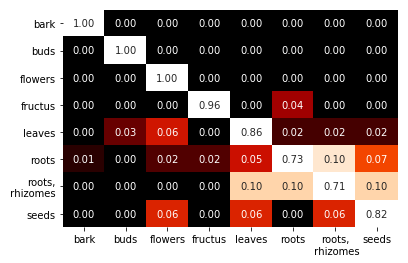

In [6]:

results_dirname = '../results/'
model_filename_base = 'parts_model_td_snn_'
results_filename = 'rank='+str(rank_mz)+model_filename_base+'+CCA.npz'
df = np.load(results_dirname+results_filename)
accuracies = df['accuracies']
f1s = df['f1s']
cms = df['confusion_matrices']


medAcc = np.median(accuracies, axis=0)
medF1 = np.median(f1s, axis=0)
medCMs = np.median(cms, axis=0)

print 'Median accuracy: train=%.4f test=%.4f test2=%.4f' % (medAcc[0], medAcc[1], medAcc[2])
print 'Median F1: train=%.4f test=%.4f test2=%.4f' % (medF1[0], medF1[1], medF1[2])
clsnms = ['bark', 'buds', 'flowers', 'fructus', 'leaves', 'roots', 'roots,\n rhizomes', 'seeds']
df = pd.DataFrame(medCMs, columns=clsnms)
df['names'] = clsnms
df = df.set_index('names')
medCMs /= np.sum(medCMs, axis=1, keepdims=True)
msk1 = medCMs.copy()
np.fill_diagonal(msk1, 0.)
sns.heatmap(
    medCMs, annot=True, vmin=msk1.min(), vmax=1.05*msk1.max(),
    xticklabels=clsnms, yticklabels=clsnms, cbar=None,
    fmt='.2f', cmap='gist_heat', #mask=np.eye(len(clsnms))
)
plt.savefig('parts_sntd.pdf')

Median accuracy: train=0.9060 test=0.7994 test2=0.8409
Median F1: train=0.9087 test=0.8080 test2=0.8563


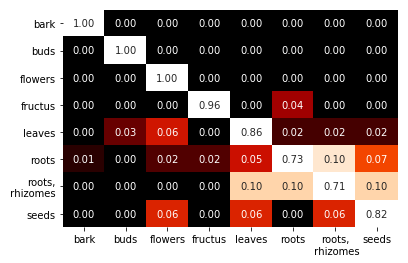

In [6]:

results_dirname = '../results/'
model_filename_base = 'parts_model_td_snn_'
results_filename = 'rank='+str(rank_mz)+model_filename_base+'+CCA.npz'
df = np.load(results_dirname+results_filename)
accuracies = df['accuracies']
f1s = df['f1s']
cms = df['confusion_matrices']


medAcc = np.median(accuracies, axis=0)
medF1 = np.median(f1s, axis=0)
medCMs = np.median(cms, axis=0)

print 'Median accuracy: train=%.4f test=%.4f test2=%.4f' % (medAcc[0], medAcc[1], medAcc[2])
print 'Median F1: train=%.4f test=%.4f test2=%.4f' % (medF1[0], medF1[1], medF1[2])
clsnms = ['bark', 'buds', 'flowers', 'fructus', 'leaves', 'roots', 'roots,\n rhizomes', 'seeds']
df = pd.DataFrame(medCMs, columns=clsnms)
df['names'] = clsnms
df = df.set_index('names')
medCMs /= np.sum(medCMs, axis=1, keepdims=True)
msk1 = medCMs.copy()
np.fill_diagonal(msk1, 0.)
sns.heatmap(
    medCMs, annot=True, vmin=msk1.min(), vmax=1.05*msk1.max(),
    xticklabels=clsnms, yticklabels=clsnms, cbar=None,
    fmt='.2f', cmap='gist_heat', #mask=np.eye(len(clsnms))
)
plt.savefig('parts_sntd.pdf')